In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType

from reni.configs.reni_config import RENIField
from reni.configs.sh_sg_envmap_configs import SHField, SGField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    if 'latent_dim' in config['pipeline']['model']['field'].keys():
        
        model_config = RENIField.config
        model_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
        model_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
        if config['pipeline']['datamanager']['dataparser']['eval_mask_path'] is not None:
            eval_mask_path = Path(os.path.join(*config['pipeline']['datamanager']['dataparser']['eval_mask_path']))
            model_config.pipeline.datamanager.dataparser.eval_mask_path = eval_mask_path
        else:
            model_config.pipeline.datamanager.dataparser.eval_mask_path = None
        if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
        else:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
        model_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
        model_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
        model_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
        model_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
        model_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
        model_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
        model_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
        model_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
        model_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
        model_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
        model_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
        model_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
        model_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
        model_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
        model_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
        model_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
        model_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
        model_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    elif 'spherical_harmonic_order' in config['pipeline']['model']['field'].keys():
        model_config = SHField.config
        model_config.pipeline.model.field.spherical_harmonic_order = config['pipeline']['model']['field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['field'].keys():
        model_config = SGField.config
        model_config.pipeline.model.field.row_col_gaussian_dims = config['pipeline']['model']['field']['row_col_gaussian_dims']

    pipeline: RENIPipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    print(model.field.train_mu.shape)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model


pipeline, datamanager, model = load_model(Path('/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100'))
# pipeline, datamanager, model = load_model(Path('/workspace/outputs/reni/reni/2023-09-18_104030'))

print('Model loaded')

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

torch.Size([3346, 100, 3])
Model loaded


In [2]:
metrics_dict = pipeline.get_average_eval_image_metrics(optimise_latents=False)
metrics_dict

Output()

/home/user/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming
release, it will be required to pass the indexing argument. (Triggered internally at 
../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

/home/user/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing 
`spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import 
`spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

{'psnr_hdr': 35.0915641784668,
 'ssim_hdr': 0.922370195388794,
 'lpips_hdr': 0.3086727559566498,
 'psnr_ldr': 22.09389877319336,
 'ssim_ldr': 0.5509666204452515,
 'lpips_ldr': 0.5156964659690857,
 'num_rays_per_sec': 449574.09375,
 'fps': 54.8796501159668}

In [3]:
metrics_dict

{'psnr_hdr': 35.0915641784668,
 'ssim_hdr': 0.922370195388794,
 'lpips_hdr': 0.3086727559566498,
 'psnr_ldr': 22.09389877319336,
 'ssim_ldr': 0.5509666204452515,
 'lpips_ldr': 0.5156964659690857,
 'num_rays_per_sec': 431989.53125,
 'fps': 52.733097076416016}

In [3]:
metrics_dict

{'psnr_hdr': 32.53045654296875,
 'ssim_hdr': 0.886318564414978,
 'lpips_hdr': 0.47305697202682495,
 'psnr_ldr': 20.144384384155273,
 'ssim_ldr': 0.4585205316543579,
 'lpips_ldr': 0.7635605335235596,
 'num_rays_per_sec': 597393.75,
 'fps': 72.92404174804688}

In [2]:
project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

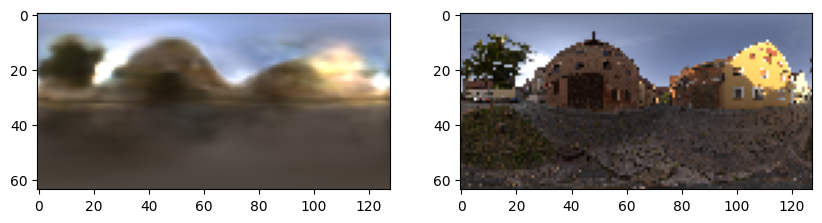

In [18]:
model.eval()
idx, ray_bundle, batch = datamanager.next_eval_image(8)
H, W = model.metadata["image_height"], model.metadata["image_width"]

# High res image:
H = 64
W = H * 2
cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(H, dtype=torch.float32).repeat(1)
fy = torch.tensor(H, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(0).flatten().to(device)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx

batch['image'] = batch['image'].to(device)

# we need ray_samples for the field
if len(ray_bundle.directions.shape) == 3: # [2, num_rays, 3]
    assert model.config.loss_inclusions['scale_inv_grad_loss']
    assert ray_bundle.directions.shape[0] == 2
    # then we are using the finite diff gradient matching loss
    # and the ray_bundle is of shape [2, num_rays, 3]
    # we the second half of the rays are just the directions rolled by 1
    ray_samples = model.create_ray_samples(ray_bundle.origins[0], ray_bundle.directions[0], ray_bundle.camera_indices[0])
else:
    ray_samples = model.create_ray_samples(ray_bundle.origins, ray_bundle.directions, ray_bundle.camera_indices)

if model.field.old_implementation:
    get_rotation = rot_y
else:
    get_rotation = rot_z

rotation = get_rotation(torch.tensor(np.deg2rad(0.0)).float())
rotation = rotation.to(device)

# field_outputs = model.field.forward(ray_samples, rotation=rotation, latent_codes=torch.randn(1, model.field.latent_dim, 3).repeat(ray_samples.shape[0], 1, 1).to(device))
# field_outputs = model.field.forward(ray_samples, rotation=rotation, latent_codes=torch.zeros(ray_samples.shape[0], model.field.latent_dim, 3).to(device))
field_outputs = model.field.forward(ray_samples, rotation=None)

outputs = {
    "rgb": field_outputs[RENIFieldHeadNames.RGB],
    "mu": field_outputs[RENIFieldHeadNames.MU],
    "log_var": field_outputs[RENIFieldHeadNames.LOG_VAR],
}

outputs['rgb'] = outputs['rgb'].reshape(H, W, 3)

pred_img = model.field.unnormalise(outputs['rgb'])
gt_img = model.field.unnormalise(batch['image'].reshape(model.metadata["image_height"], model.metadata["image_width"], 3))

pred_img = linear_to_sRGB(pred_img, use_quantile=True)
gt_img = linear_to_sRGB(gt_img, use_quantile=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pred_img.cpu().detach().numpy())
ax[1].imshow(gt_img.cpu().detach().numpy())

/tmp/ipykernel_558/1366327164.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_filename).astype("float32")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


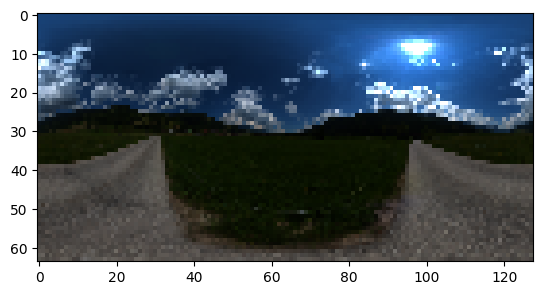

In [5]:
import imageio
image_filename = '/workspace/data/RENI_HDR/val/00001.exr'
image = imageio.imread(image_filename).astype("float32")

if len(image.shape) == 2:
    image = image[:, :, None].repeat(3, axis=2)

# make any inf values equal to max non inf
image[image == np.inf] = np.nanmax(image[image != np.inf])
# make any values less than zero equal to min non negative
image[image <= 0] = np.nanmin(image[image > 0])
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


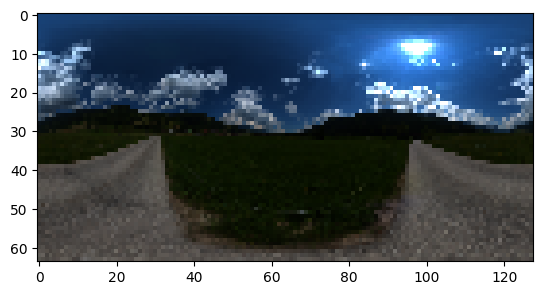

In [9]:
plt.imshow(torch.exp(datamanager.eval_dataset[0]['image']))

/home/user/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


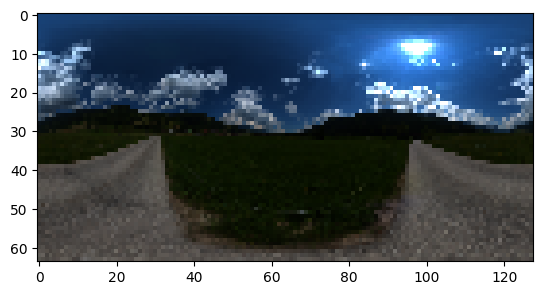

In [2]:
_, _, batch = datamanager.next_eval_image(0)
plt.imshow(torch.exp(batch['image'].reshape(64, 128, 3)).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


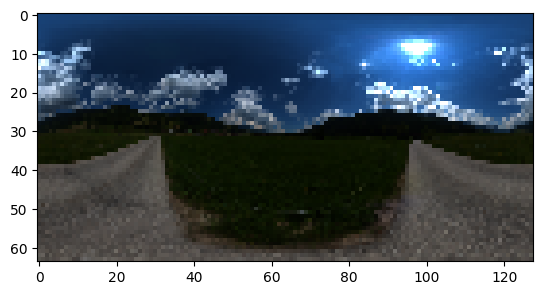

In [4]:
plt.imshow(image)

In [56]:
gt = batch["image"][0].reshape(H, W, 3)
gt = gt.unsqueeze(0).permute(0, 3, 1, 2)
pred = outputs["rgb"].reshape(H, W, 3)
pred = pred.unsqueeze(0).permute(0, 3, 1, 2)

gt = gt.to(device)
pred = pred.to(device)

scale = (gt * pred).sum() / (pred * pred).sum()
pred = scale * pred

gt = torch.exp(gt)
pred = torch.exp(pred)

model.psnr(preds=pred, target=gt)


tensor(32.5115, device='cuda:0', grad_fn=<SqueezeBackward0>)

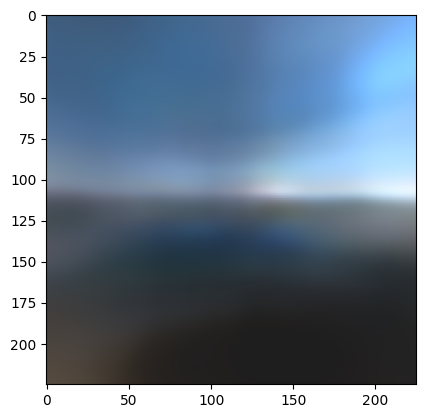

In [ ]:
import torch

from nerfstudio.cameras.cameras import Cameras

from reni_neus.utils.utils import look_at_target
from reni.utils.colourspace import linear_to_sRGB


camera_positions = torch.tensor([[0.0, 1.0, 0.0]])

target_positions = torch.tensor([[0.0, 0.0, 0.0]])

c2w = look_at_target(camera_positions, target_positions, up_vector=torch.tensor([0.0, 0.0, 1.0]))[:, :3, :]

H, W = 225, 225
fx, fy = 100.0, 100.0
cx, cy = W / 2, H / 2

camera = Cameras(camera_to_worlds=c2w, fx=fx, fy=fy, cx=cx, cy=cy)

ray_bundle = camera.generate_rays(camera_indices=0, keep_shape=True)

ray_bundle.camera_indices = ray_bundle.camera_indices.to('cuda:0').reshape(-1)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * 4
ray_bundle.directions = ray_bundle.directions.to('cuda:0').reshape(-1, 3)

output = model.field.forward(ray_bundle)
img = output[RENIFieldHeadNames.RGB].reshape(225, 225, 3)
min_val, max_val = model.field.min_max
# need to unnormalize the image from between -1 and 1
img = 0.5 * (img + 1) * (max_val - min_val) + min_val
img = torch.exp(img)
plt.imshow(linear_to_sRGB(img).cpu().detach().numpy())

In [ ]:
from reni.illumination_fields.sh_illumination_field import getCoefficientsFromImage, shReconstructSignal, shEvaluate, SphericalHarmonicIlluminationFieldConfig, SphericalHarmonicIlluminationField
import imageio
from reni.utils.colourspace import linear_to_sRGB
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

image = imageio.imread('/workspace/blue_photo_studio_1k.exr').astype("float32")
# make any inf values equal to max non inf
image[image == np.inf] = np.nanmax(image[image != np.inf])
# make any values less than zero equal to min non negative
image[image <= 0] = np.nanmin(image[image > 0])

/tmp/ipykernel_15250/3709309694.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('/workspace/blue_photo_studio_1k.exr').astype("float32")


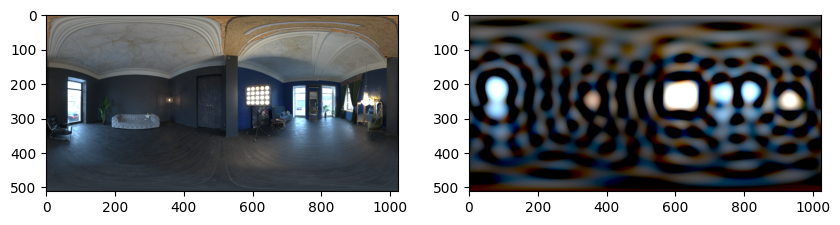

In [ ]:
ibl_coeffs = getCoefficientsFromImage(torch.from_numpy(image).to('cpu'), 20, device='cpu')

sh_radiance_map = shReconstructSignal(ibl_coeffs, width=image.shape[1], device='cpu')

# plot image and sh radiance map
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(linear_to_sRGB(torch.from_numpy(image)).numpy())
axs[1].imshow(linear_to_sRGB(sh_radiance_map).cpu().detach().numpy())

In [ ]:
config = SphericalHarmonicIlluminationFieldConfig(
    spherical_harmonic_order=20,
)

sh_field = SphericalHarmonicIlluminationField(config=config, num_train_data=1, num_eval_data=1)
sh_field.train_latent_codes.data = ibl_coeffs.unsqueeze(0).to('cpu')
sh_field.eval_latent_codes.data = ibl_coeffs.unsqueeze(0).to('cpu')

sh_basis_matrix shape = torch.Size([500000, 441]), sh_coeffs shape = torch.Size([500000, 441, 3])


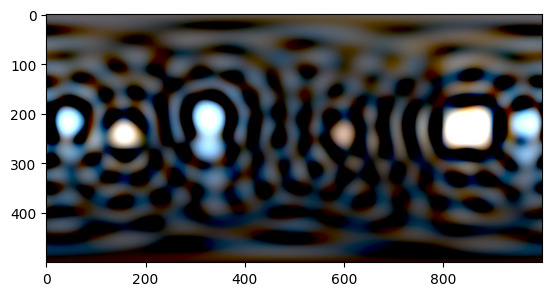

In [ ]:
from nerfstudio.cameras.cameras import Cameras, CameraType
from reni.field_components.field_heads import RENIFieldHeadNames

rotation = rotation_matrix(np.array([0, 0, 1]), np.deg2rad(90))
rotation = rotation.to('cpu')

cx = torch.tensor(1000 // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(500 // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(500, dtype=torch.float32).repeat(1)
fy = torch.tensor(500, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = sh_field.forward(ray_bundle, rotation)

img = output[RENIFieldHeadNames.RGB].reshape(500, 1000, 3)
plt.imshow(linear_to_sRGB(img).cpu().detach().numpy())


sh_basis_matrix shape = torch.Size([250000, 441]), sh_coeffs shape = torch.Size([250000, 441, 3])


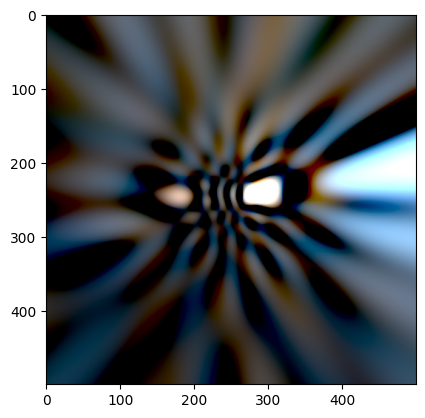

In [ ]:
import torch

from nerfstudio.cameras.cameras import Cameras

from reni_neus.utils.utils import look_at_target

camera_positions = torch.tensor([[0.0, 1.0, 0.0]])

target_positions = torch.tensor([[0.0, 0.0, 0.0]])

c2w = look_at_target(camera_positions, target_positions, up_vector=torch.tensor([0.0, 0.0, 1.0]))[:, :3, :]

H, W = 500, 500
fx, fy = 50.0, 50.0
cx, cy = W / 2, H / 2

camera = Cameras(camera_to_worlds=c2w, fx=fx, fy=fy, cx=cx, cy=cy)

ray_bundle = camera.generate_rays(camera_indices=0, keep_shape=True)

ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = sh_field.forward(ray_bundle)
img = output[RENIFieldHeadNames.RGB].reshape(500, 500, 3)
plt.imshow(linear_to_sRGB(img).cpu().detach().numpy())

In [ ]:
from reni.illumination_fields.sh_illumination_field import getCoefficientsFromImage, shReconstructSignal, shEvaluate
from reni.illumination_fields.environment_map_field import EnvironmentMapField, EnvironmentMapFieldConfig
from reni.field_components.field_heads import RENIFieldHeadNames
import imageio
from reni.utils.colourspace import linear_to_sRGB
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
config = EnvironmentMapFieldConfig(
    path='/workspace/blue_photo_studio_1k.exr',
    resolution=(64, 128),
    trainable=False,
    apply_padding=True,
    fixed_decoder=True
)

envmap_field = EnvironmentMapField(config, 10, 10)
envmap_field = envmap_field.to('cpu')
equiH = envmap_field.train_envmaps.shape[2]
equiW = 2 * equiH

In [ ]:
from nerfstudio.cameras.cameras import Cameras, CameraType

rotation = rotation_matrix(np.array([0, 0, 1]), np.deg2rad(90))
rotation = rotation.to('cpu')

cx = torch.tensor(equiW // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(equiH // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(equiH, dtype=torch.float32).repeat(1)
fy = torch.tensor(equiH, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = envmap_field.forward(ray_bundle, rotation=rotation)

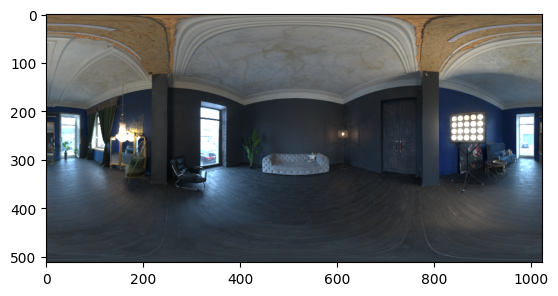

In [ ]:
img = output[RENIFieldHeadNames.RGB].reshape(equiH, equiW, 3)
plt.imshow(linear_to_sRGB(img).cpu().detach().numpy())

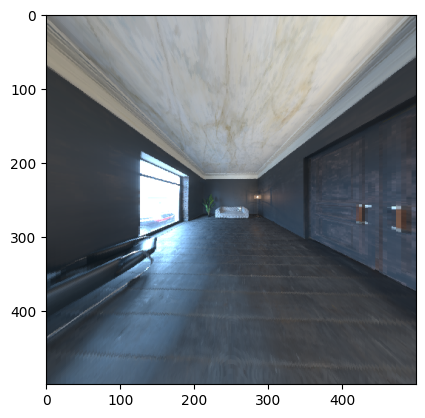

In [ ]:
import torch

from nerfstudio.cameras.cameras import Cameras

from reni_neus.utils.utils import look_at_target

camera_positions = torch.tensor([[0.0, 1.0, 0.0]])

target_positions = torch.tensor([[0.0, 0.0, 0.0]])

c2w = look_at_target(camera_positions, target_positions, up_vector=torch.tensor([0.0, 0.0, 1.0]))[:, :3, :]

H, W = 500, 500
fx, fy = 50.0, 50.0
cx, cy = W / 2, H / 2

camera = Cameras(camera_to_worlds=c2w, fx=fx, fy=fy, cx=cx, cy=cy)

ray_bundle = camera.generate_rays(camera_indices=0, keep_shape=True)

ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = envmap_field.forward(ray_bundle, rotation)
img = output[RENIFieldHeadNames.RGB].reshape(500, 500, 3)
plt.imshow(linear_to_sRGB(img).cpu().detach().numpy())

In [ ]:
from reni.illumination_fields.sh_illumination_field import getCoefficientsFromImage, shReconstructSignal, shEvaluate
from reni.illumination_fields.environment_map_field import EnvironmentMapField, EnvironmentMapFieldConfig
from reni.field_components.field_heads import RENIFieldHeadNames
import imageio
from reni.utils.colourspace import linear_to_sRGB
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

config = EnvironmentMapFieldConfig(
    path='/workspace/blue_photo_studio_1k.exr',
    resolution=(64, 128),
    trainable=False,
    apply_padding=True,
    fixed_decoder=True
)

envmap_field = EnvironmentMapField(config, 10, 10)
envmap_field = envmap_field.to('cpu')
equiH = envmap_field.train_envmaps.shape[2]
equiW = 2 * equiH

from nerfstudio.cameras.cameras import Cameras, CameraType

cx = torch.tensor(equiW // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(equiH // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(equiH, dtype=torch.float32).repeat(1)
fy = torch.tensor(equiH, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = envmap_field.forward(ray_bundle)
colours = output[RENIFieldHeadNames.RGB].reshape(equiH, equiW, 3)
colours = linear_to_sRGB(colours)

import plotly.graph_objects as go

# plot ray directions as points with colours from colours
fig = go.Figure(data=[go.Scatter3d(
    x=ray_bundle.directions[:, 0].cpu().detach().numpy(),
    y=ray_bundle.directions[:, 1].cpu().detach().numpy(),
    z=ray_bundle.directions[:, 2].cpu().detach().numpy(),
    mode='markers',
    marker=dict(
        size=1,
        color=colours.reshape(-1, 3).cpu().detach().numpy(),
        opacity=1.0
    )
)])

fig.show()

In [ ]:
from reni.illumination_fields.sh_illumination_field import getCoefficientsFromImage, shReconstructSignal, shEvaluate
from reni.illumination_fields.environment_map_field import EnvironmentMapField, EnvironmentMapFieldConfig
from reni.field_components.field_heads import RENIFieldHeadNames
import imageio
from reni.utils.colourspace import linear_to_sRGB
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

config = EnvironmentMapFieldConfig(
    path='/workspace/blue_photo_studio_1k.exr',
    resolution=(64, 128),
    trainable=False,
    apply_padding=True,
    fixed_decoder=True
)

envmap_field = EnvironmentMapField(config, 10, 10)
envmap_field = envmap_field.to('cpu')
equiH = envmap_field.train_envmaps.shape[2]
equiW = 2 * equiH

from nerfstudio.cameras.cameras import Cameras, CameraType

cx = torch.tensor(equiW // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(equiH // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(equiH, dtype=torch.float32).repeat(1)
fy = torch.tensor(equiH, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu').reshape(-1)
ray_bundle.directions = ray_bundle.directions.to('cpu').reshape(-1, 3)

output = envmap_field.forward(ray_bundle)
colours = output[RENIFieldHeadNames.RGB].reshape(equiH, equiW, 3)
colours = linear_to_sRGB(colours)

# import plotly.graph_objects as go

# # plot ray directions as points with colours from colours
# fig = go.Figure(data=[go.Scatter3d(
#     x=ray_bundle.directions[:, 0].cpu().detach().numpy(),
#     y=ray_bundle.directions[:, 1].cpu().detach().numpy(),
#     z=ray_bundle.directions[:, 2].cpu().detach().numpy(),
#     mode='markers',
#     marker=dict(
#         size=1,
#         color=colours.reshape(-1, 3).cpu().detach().numpy(),
#         opacity=1.0
#     )
# )])

# fig.show()

In [ ]:
from reni.model_components.illumination_samplers import IcosahedronSampler, IcosahedronSamplerConfig
from nerfstudio.cameras.rays import Frustums, RayBundle, RaySamples


config = IcosahedronSamplerConfig(
    num_directions=10000,
    apply_random_rotation=True,
    remove_lower_hemisphere=False
)

sampler = IcosahedronSampler(config)
ray_samples = sampler.generate_direction_samples()

ray_bundle.directions = ray_samples.frustums.directions.to('cpu').reshape(-1, 3)
ray_bundle.camera_indices = torch.zeros_like(ray_bundle.directions[:, 0]).to('cpu').reshape(-1).type_as(ray_bundle.camera_indices)

output = envmap_field.forward(ray_bundle)
colours = output[RENIFieldHeadNames.RGB]
colours = linear_to_sRGB(colours)

import plotly.graph_objects as go

# plot ray directions as points with colours from colours
fig = go.Figure(data=[go.Scatter3d(
    x=ray_bundle.directions[:, 0].cpu().detach().numpy(),
    y=ray_bundle.directions[:, 1].cpu().detach().numpy(),
    z=ray_bundle.directions[:, 2].cpu().detach().numpy(),
    mode='markers',
    marker=dict(
        size=1,
        color=colours.reshape(-1, 3).cpu().detach().numpy(),
        opacity=1.0
    )
)])

fig.show()

In [ ]:
ray_samples.shape

torch.Size([10242])

In [ ]:
print(ray_bundle.directions.shape)
print(torch.tensor([[-0.2080, -0.5051, -0.8376],[-0.8297, -0.3624,  0.4246],[-0.5180,  0.7833, -0.3437]]).shape)


torch.Size([10242, 3])
torch.Size([3, 3])


In [ ]:
import imageio
import numpy as np

H = 64
W = 128

all_black = np.zeros((H, W, 3))
all_black = all_black.astype(np.float32)

# save as all_black.exr
imageio.imwrite('all_black.exr', all_black)

In [1]:
from reni.illumination_fields.sg_illumination_field import SphericalGaussianField, SphericalGaussianFieldConfig

config = SphericalGaussianFieldConfig(
    row_col_gaussian_dims=(3, 3),
    channel_dim=3,
)

field = SphericalGaussianField(
    config=config,
    num_train_data=10,
    num_eval_data=10,
    normalisations={},
)

In [2]:
from nerfstudio.cameras.rays import Frustums, RayBundle, RaySamples
from nerfstudio.cameras.cameras import Cameras, CameraType
import torch

cx = torch.tensor(128 // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(64 // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(64, dtype=torch.float32).repeat(1)
fy = torch.tensor(64, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     
cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
ray_bundle = ray_bundle.reshape(-1)
ray_bundle.camera_indices = ray_bundle.camera_indices.to('cpu')
ray_bundle.directions = ray_bundle.directions.to('cpu')

ray_samples = RaySamples(frustums=Frustums(origins=ray_bundle.origins,
                                            directions=ray_bundle.directions,
                                            starts=torch.zeros_like(ray_bundle.origins[:, 0]),
                                            ends=torch.ones_like(ray_bundle.origins[:, 0]),
                                            pixel_area=torch.ones_like(ray_bundle.origins[:, 0])),
                          camera_indices=ray_bundle.camera_indices)

# get outputs
outputs = field(ray_samples, rotation=None)

In [9]:
from reni.field_components.field_heads import RENIFieldHeadNames
rgb = outputs[RENIFieldHeadNames.RGB]

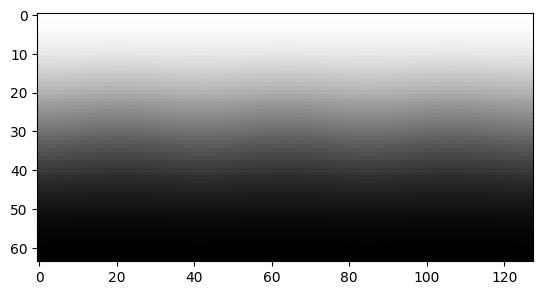

In [11]:
from matplotlib import pyplot as plt
import numpy as np

rgb = rgb.reshape(64, 128, 3)
# scale to 0-1
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
plt.imshow(rgb.cpu().detach().numpy())

/tmp/ipykernel_92028/775852869.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/workspace/derelict_highway_midday_1k.exr').astype("float32")


TypeError: Invalid shape (512, 1024, 2, 4) for image data

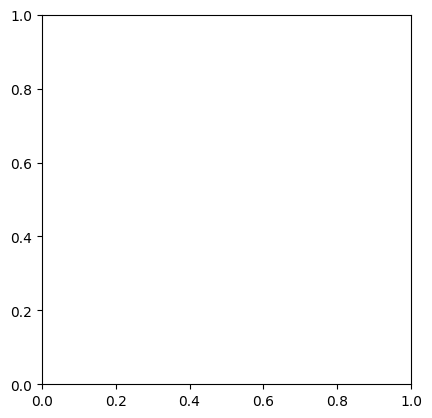

In [11]:
import imageio
import numpy as np
from matplotlib import pyplot as plt
# load image from /workspace/blue_photo_studio_1k.exr

img = imageio.imread('/workspace/derelict_highway_midday_1k.exr').astype("float32")

# ensure no inf
img[img == np.inf] = np.nanmax(img[img != np.inf])
# ensure no negative
img[img <= 0] = np.nanmin(img[img > 0])
# create image of gradients and plot 
# noramlise gradients
grad_x = (grad_x - np.min(grad_x)) / (np.max(grad_x) - np.min(grad_x))
grad_y = (grad_y - np.min(grad_y)) / (np.max(grad_y) - np.min(grad_y))
grad_img = np.stack([grad_x, grad_y], axis=2)
plt.imshow(grad_img)

In [6]:
from nerfstudio.cameras.rays import Frustums, RayBundle, RaySamples
from nerfstudio.cameras.cameras import Cameras, CameraType
import torch
import plotly.graph_objects as go

cx = torch.tensor(32 // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(16 // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(16, dtype=torch.float32).repeat(1)
fy = torch.tensor(16, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[-1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)
                     
cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(camera_indices=0, keep_shape=True)
directions = ray_bundle.directions.reshape(-1, 3) # (H, W, 3)
directions_flat = directions.reshape(-1, 3) # (H*W, 3)

directions_roll = torch.roll(directions, 1, 0)
directions_roll_flat = directions_roll.reshape(-1, 3) # (H*W, 3)

# Plot the rays as a 3D scatter plot with vertical Z axis.
fig = go.Figure(data=[go.Scatter3d(x=directions_flat[:, 0], y=directions_flat[:, 1], z=directions_flat[:, 2],
                                    mode='markers', marker=dict(size=4))])

# add rolled directions
fig.add_trace(go.Scatter3d(x=directions_roll_flat[:, 0], y=directions_roll_flat[:, 1], z=directions_roll_flat[:, 2],
                                    mode='markers', marker=dict(size=2)))

fig.show()




/tmp/ipykernel_595/3157876297.py:8: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



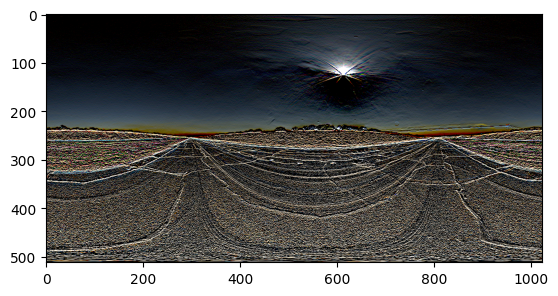

In [13]:
import imageio
import numpy as np
import torch
import matplotlib.pyplot as plt

from reni.utils.colourspace import linear_to_sRGB

img = imageio.imread('/workspace/derelict_highway_midday_1k.exr').astype("float32")

# ensure no inf
img[img == np.inf] = np.nanmax(img[img != np.inf])
# ensure no negative
img[img <= 0] = np.nanmin(img[img > 0])

# ensure only 3 channels
img = img[:, :, :3]

img = torch.from_numpy(img)

finite_diff = img - torch.roll(img, 1, 0)

finite_diff = linear_to_sRGB(finite_diff)

# plot finite diff
plt.imshow(finite_diff.numpy())

In [8]:
import imageio
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy

from reni.utils.colourspace import linear_to_sRGB

img = imageio.imread('/workspace/derelict_highway_midday_1k.exr').astype("float32")

# ensure no inf
img[img == np.inf] = np.nanmax(img[img != np.inf])
# ensure no negative
img[img <= 0] = np.nanmin(img[img > 0])

# ensure only 3 channels
img = img[:, :, :3]

img = torch.from_numpy(img).requires_grad_(True)

image = img.detach().cpu().numpy()
# Compute gradient and laplacian       
grads_x = scipy.ndimage.sobel(image, axis=1)
grads_y = scipy.ndimage.sobel(image, axis=2)
grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
        
grads = torch.stack((grads_x, grads_y), dim=-1)

# take the norm of the gradients
grads = torch.norm(grads, dim=-1)

/tmp/ipykernel_5210/216128515.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/workspace/derelict_highway_midday_1k.exr').astype("float32")


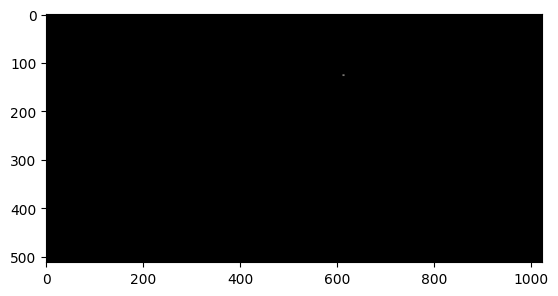

In [9]:
# normalise gradients between 0 and 1
grads = grads - grads.min()
grads = grads / grads.max()
plt.imshow(grads.cpu().detach().numpy())

In [2]:
import torch
from nerfstudio.utils import colormaps, colors, misc
from nerfstudio.utils.colormaps import ColormapOptions
from matplotlib import pyplot as plt

cache_path = '/workspace/outputs/ddf/cache/lk2_data.pt'

data = torch.load(cache_path)

In [12]:
depth_1 = data[1]['termination_dist']
depth_2 = data[2]['termination_dist']

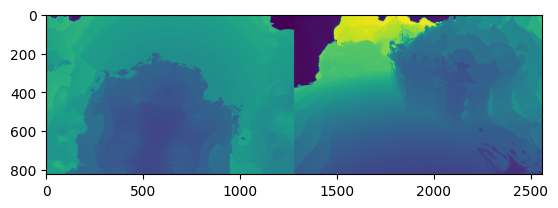

In [14]:
combined_depth = torch.cat([depth_1, depth_2], dim=1)

plt.imshow(combined_depth.cpu().detach().numpy())

In [20]:
for i in range(len(data)):
    print(data[i]['termination_dist'].min())

tensor(0.2979, device='cuda:0')
tensor(0.3677, device='cuda:0')
tensor(0.3939, device='cuda:0')
tensor(0.2600, device='cuda:0')
tensor(0.4155, device='cuda:0')
tensor(0.3929, device='cuda:0')
tensor(0.4128, device='cuda:0')
tensor(0.4062, device='cuda:0')


In [34]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch

def adjusted_sigmoid(tensor, a=15, b=0.95):
    return 1 / (1 + torch.exp(-a * (tensor - b)))

def to_rgb_tensor(gray_tensor, cmap='viridis'):
    # Ensure the tensor is in the range [0, 1]
    normalized_tensor = (gray_tensor - 0.0) / (2.0 - 0.0)
    
    # Convert to numpy and use colormap to get RGB values
    cmapped = cm.get_cmap(cmap)(normalized_tensor.cpu().numpy())
    
    # Convert back to tensor and take only RGB channels (discard alpha)
    rgb_tensor = torch.tensor(cmapped[..., :3])
    
    return rgb_tensor

scaled_tensor = adjusted_sigmoid(depth_1.squeeze())
rgb_depth_1 = to_rgb_tensor(scaled_tensor)
# save as rgb_depth_1.png
plt.imsave('rgb_depth_1.png', rgb_depth_1.cpu().detach().numpy())

/tmp/ipykernel_117700/173120305.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapped = cm.get_cmap(cmap)(normalized_tensor.cpu().numpy())
